# 1. General information

This project is prepared by an analyst working for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.
We are going to carry out a preliminary analysis of the plans based on a relatively small client selection. We'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Our job is to analyze clients' behavior and determine which prepaid plan brings in more revenue.

**The main goal of this analysis is to determine which of the selected plans - Surf or Ultimate is bringing more revenue.**

In [ ]:
# Importing all libraries
import pandas as pd
import datetime
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from functools import reduce
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import random
import math

In [ ]:
# Loading dataframes

try:
    users = pd.read_csv("/content/drive/MyDrive/csv_fies/megaline_users.csv")
    plans = pd.read_csv("/content/drive/MyDrive/csv_fies/megaline_plans.csv")
    messages = pd.read_csv("/content/drive/MyDrive/csv_fies/megaline_messages.csv")
    internet = pd.read_csv("/content/drive/MyDrive/csv_fies/megaline_internet.csv")
    calls = pd.read_csv("/content/drive/MyDrive/csv_fies/megaline_calls.csv")
except:
    calls = pd.read_csv("/datasets/megaline_calls.csv")
    internet = pd.read_csv("/datasets/megaline_internet.csv")
    messages = pd.read_csv("/datasets/megaline_messages.csv")
    plans = pd.read_csv("/datasets/megaline_plans.csv")
    users = pd.read_csv("/datasets/megaline_users.csv")

Since we have several dataframes we will create a list of them so we can automate a little bit our process.

In [ ]:
# Creating a list of dataframes to loop through
list_of_sets = [users, plans, messages, internet, calls]
list_of_names = ['Megaline users', 'Surf and Ultimate plans', 'Messages', 'Internet', 'Calls']

In [ ]:
# Getting general information about the dataframes - info(), head(), shape()
for i, j in zip(list_of_names, list_of_sets):
    print()
    print('Information on', i)
    print()
    print(j.info())
    print()
    print(j.head())
    print()
    print(j.shape)
    print("-" * 60)


Information on Megaline users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1

We have 5 dataframes: users, plans, messages, internet, calls. Lets describe each:
1. The `users` table (data on users):
* user_id — unique user identifier
* first_name — user's name
* last_name — user's last name
* age — user's age (years)
* reg_date — subscription date (dd, mm, yy) - the info() shows that this data represented as object, we will need to fix this with pd.to_datetime to a proper date format
* churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this data was retrieved)
* city — user's city of residence
* plan — calling plan name

1. The `calls` table (data on calls):
* id — unique call identifier
* call_date — call date - another inappropriate format of date, needs fixing
* duration — call duration (in minutes) - will need to round them to minutes
* user_id — the identifier of the user making the call


1. The `messages` table (data on texts):
* id — unique text message identifier
* message_date — text message date - also an object data type - we defined that we need to fix it to datetime format
* user_id — the identifier of the user sending the text


1. The `internet` table (data on web sessions):
* id — unique session identifier
* mb_used — the volume of data spent during the session (in megabytes) - we will need to convert those to gigabytes
* session_date — web session date - another date info stored as object
* user_id — user identifier


1. The `plans` table (data on the plans):
* plan_name — calling plan name
* usd_monthly_fee — monthly charge in US dollars
* minutes_included — monthly minute allowance
* messages_included — monthly text allowance
* mb_per_month_included — data volume allowance (in megabytes)
* usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
* usd_per_message — price per text after exceeding the package limits
* usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

Some facts we can learn from those columns about our data: 
- There are 500 unique identifiers of users with their names, age, information about the period of time they are being our clients, different plans (Surf and Ultimate), from different regions. 

- We have a reference table with fees and services included in each package.

- Also we have three tables with each users' calls, messages and traffic usage records.

Now that we had a glance at our data we can start with preprocessing.

In [ ]:
# Check missing values
for i, j in zip(list_of_sets, list_of_names):
    print(j)
    print()
    print(i.isnull().sum())
    print("-"*30)
    print()

Megaline users

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64
------------------------------

Surf and Ultimate plans

messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64
------------------------------

Messages

id              0
user_id         0
message_date    0
dtype: int64
------------------------------

Internet

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64
------------------------------

Calls

id           0
user_id      0
call_date    0
duration     0
dtype: int64
------------------------------



We can see almost all of the values are missing in the dataframe with information about users, in the `churn_date` column. According to the description we know that if the data here is missing it means that the user was active by the **end of 2018**, so this explenation lets us fill those missing values with the last day of 2018: **2018-12-31**, that will give us an opportunity to compare `reg_date` and `churn_date`, for instance.

# 2 Data preprocessing

# 2.1 Fixing the data types

In [ ]:
# Make sure there is no other year than 2018
internet['session_date'].min()
internet['session_date'].max()

users['reg_date'].min()
users['reg_date'].max()

messages['message_date'].min()
messages['message_date'].max()

calls['call_date'].min()
calls['call_date'].max()

'2018-01-15'

'2018-12-31'

'2018-01-01'

'2018-12-31'

'2018-01-15'

'2018-12-31'

'2018-01-15'

'2018-12-31'

In [ ]:
# Correcting all the columns with the wrong datatype for dates
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['reg_date'].dtype

dtype('<M8[ns]')

In [ ]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_date'].dtype

dtype('<M8[ns]')

In [ ]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_date'].dtype

dtype('<M8[ns]')

In [ ]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_date'].dtype

dtype('<M8[ns]')

# 2.2 Checking errors

In [ ]:
# Round each minute up
calls['duration'] = np.ceil(calls['duration']).astype(int)
calls['duration']

0          9
1         14
2         15
3          6
4          5
          ..
137730     9
137731    11
137732     9
137733     1
137734    14
Name: duration, Length: 137735, dtype: int64

In [ ]:
# Fill in missing values
users['churn_date'].fillna('2018-12-31', inplace=True)
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [ ]:
users['churn_date'].head()

0   2018-12-31
1   2018-12-31
2   2018-12-31
3   2018-12-31
4   2018-12-31
Name: churn_date, dtype: datetime64[ns]

# 2.3 Checking for zeros

In [ ]:
# Define a function for finding zeros
def zero_func(frame):
    for row in frame:
        print(row, len(frame[frame[row] == 0]))

In [ ]:
# Using the list of dataframes create a loop to iterate through with the function
for name, frame in zip(list_of_names, list_of_sets):
    print(name)
    print()
    zero_func(frame)
    print()
    print('-' * 30)
    print()

Megaline users

user_id 0
first_name 0
last_name 0
age 0
city 0
reg_date 0
plan 0
churn_date 0

------------------------------

Surf and Ultimate plans

messages_included 0
mb_per_month_included 0
minutes_included 0
usd_monthly_pay 0
usd_per_gb 0
usd_per_message 0
usd_per_minute 0
plan_name 0

------------------------------

Messages

id 0
user_id 0
message_date 0

------------------------------

Internet

id 0
user_id 0
session_date 0
mb_used 13747

------------------------------

Calls

id 0
user_id 0
call_date 0
duration 26834

------------------------------



We see a lot of zeros in the calls duration and megabytes column - these might be missed calls or failed connections or even an error in logging. We need to have a look at our distribution and see if there are any outliers that can get in our way. Lets create a function for that.

In [ ]:
def percentile_func(data, parameter):  # take the percentile for it is more accurate
    data[parameter].hist(bins=60)
    plt.title('The histogram of: {}'.format(parameter))
    plt.xlabel(parameter)
    plt.ylabel('Count')
    plt.show()
    if data[parameter].mean() > data[parameter].median():
        print('The distribution is positive and is skewed to the right')
    else:
        print('The distribution is negative and is skewed to the left')
    print('-' * 55)
    print('Statistics on: {}'.format(parameter))
    print(data[parameter].describe())
    upper_limit = np.percentile(data[parameter], 99)
    lower_limit = np.percentile(data[parameter], 1)
    print('-' * 55)
    print('The upper limit of outliers outlier is:', upper_limit)
    print('The lower limit of outliers is', lower_limit)
    print('-' * 55)
    print('The outliers are considered to be values below', lower_limit, 'and above', upper_limit)
    print('We have', len(data[(data[parameter] < lower_limit)|(data[parameter] > upper_limit)]),
          "values that we can consider outliers")
    print('The share of all located outliers is: {:.2%}'.format(len(data[(data[parameter] < lower_limit)
                                                                         |(data[parameter] > upper_limit)]) 
                                                                        / len(data)))

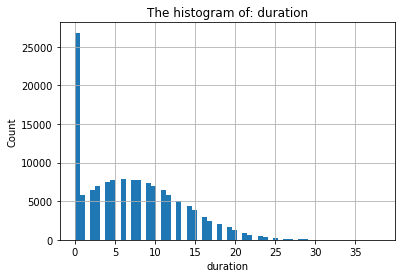

The distribution is positive and is skewed to the right
-------------------------------------------------------
Statistics on: duration
count    137735.000000
mean          7.146673
std           5.953919
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64
-------------------------------------------------------
The upper limit of outliers outlier is: 23.0
The lower limit of outliers is 0.0
-------------------------------------------------------
The outliers are considered to be values below 0.0 and above 23.0
We have 1025 values that we can consider outliers
The share of all located outliers is: 0.74%


In [ ]:
percentile_func(calls, 'duration')

As the graph shows, the form of the distribution looks normal with a little skew to the right, except for the zeros - they really stand out. The absence of them is not supposed to have any affect on out analisys, so we can eliminate them.

In [ ]:
# Ommit the zeros from calls dataframe
calls_upd = calls.query('duration !=0').reset_index()

Moving on to checking the distribution of gigabytes, let's first calculate them to a new column:

In [ ]:
# Add a column with MB converted to GB
internet['gb_used'] = internet['mb_used'] / 1024
internet.head()

,id,user_id,session_date,mb_used,gb_used
0,1000_13,1000,2018-12-29,89.86,0.087754
1,1000_204,1000,2018-12-31,0.00,0.000000
2,1000_379,1000,2018-12-28,660.40,0.644922
3,1000_413,1000,2018-12-26,270.99,0.264639
4,1000_442,1000,2018-12-27,880.22,0.859590


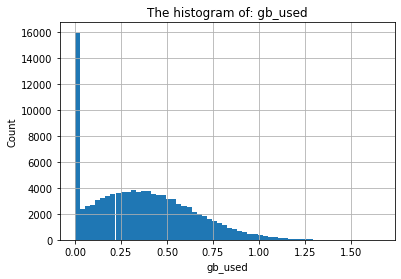

The distribution is positive and is skewed to the right
-------------------------------------------------------
Statistics on: gb_used
count    104825.000000
mean          0.358119
std           0.270674
min           0.000000
25%           0.132891
50%           0.335918
75%           0.541611
max           1.653779
Name: gb_used, dtype: float64
-------------------------------------------------------
The upper limit of outliers outlier is: 1.0549812499999995
The lower limit of outliers is 0.0
-------------------------------------------------------
The outliers are considered to be values below 0.0 and above 1.0549812499999995
We have 1049 values that we can consider outliers
The share of all located outliers is: 1.00%


In [ ]:
percentile_func(internet, 'gb_used')

Same goes for internet - we observe a distribution like normal, but the zeros stand out and don't seem to contribute to calculations.

In [ ]:
internet_upd = internet.query('mb_used !=0', inplace = True)

In [ ]:
internet_upd

To count the ammount of messages we need to aggregate the data in the messages datarame

In [ ]:
messages_piv = messages.pivot_table(index = ['user_id', 'message_date'], 
                                    values = 'id', 
                                    aggfunc = 'count')\
                        .reset_index()
messages_piv

,user_id,message_date,id
0,1000,2018-12-25,1
1,1000,2018-12-26,1
2,1000,2018-12-27,3
3,1000,2018-12-28,1
4,1000,2018-12-29,1
...,...,...,...
33238,1497,2018-12-27,4
33239,1497,2018-12-28,2
33240,1497,2018-12-29,5
33241,1497,2018-12-30,1


In [ ]:
# renaming the id column for better understanding
messages_piv.rename(columns = {'id' : 'messages_sent'}, inplace = True) 

# 2.4 Checking duplicates

In [ ]:
upd_list = [calls_upd, internet, plans, messages_piv, users]
upd_names = ['Calls', 'Internet', 'Plans', 'Messages', 'Megaline users']

In [ ]:
for name, frame in zip(upd_names, upd_list):
    if frame.duplicated().sum() > 0:
        result = name
    else:
        result = 'No duplicates'
print(result)


No duplicates


No duplicates in our site - lets move on to enriching our data.

# 2.5 Adding columns

In [ ]:
# Adding a month column to work with
internet['month'] = pd.to_datetime(internet['session_date']).dt.month
internet.head()

,id,user_id,session_date,mb_used,gb_used,month
0,1000_13,1000,2018-12-29,89.86,0.087754,12
2,1000_379,1000,2018-12-28,660.40,0.644922,12
3,1000_413,1000,2018-12-26,270.99,0.264639,12
4,1000_442,1000,2018-12-27,880.22,0.859590,12
5,1001_0,1001,2018-08-24,284.68,0.278008,8


In [ ]:
messages_piv['month'] = pd.to_datetime(messages_piv['message_date']).dt.month
messages_piv.head()

,user_id,message_date,messages_sent,month
0,1000,2018-12-25,1,12
1,1000,2018-12-26,1,12
2,1000,2018-12-27,3,12
3,1000,2018-12-28,1,12
4,1000,2018-12-29,1,12


In [ ]:
calls_upd['month'] = pd.to_datetime(calls_upd['call_date']).dt.month
calls_upd.head()

,index,id,user_id,call_date,duration,month
0,0,1000_93,1000,2018-12-27,9,12
1,1,1000_145,1000,2018-12-27,14,12
2,2,1000_247,1000,2018-12-27,15,12
3,3,1000_309,1000,2018-12-28,6,12
4,4,1000_380,1000,2018-12-30,5,12


# 2.6 Calculations

The goal of our project is to compare average revenue for different groups. To do that we first need to count the ammount of messages, call minutes and gigabytes for each user per month, then to determine excess in usage and count the revenue for each user according to plans' fee.

In [ ]:
# Count the number of text messages sent per month
messages_count = messages_piv.groupby(['user_id', 'month'], as_index=False)['messages_sent'].count()
messages_count.head()

,user_id,month,messages_sent
0,1000,12,7
1,1001,8,14
2,1001,9,23
3,1001,10,25
4,1001,11,19


In [ ]:
# Count the minutes used per month
calls_sum = calls_upd.groupby(['user_id', 'month'], as_index=False)['duration'].sum()
calls_sum.head()

,user_id,month,duration
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426


In [ ]:
# Count the volume of data per month and round the summ up
gb_volume = internet.groupby(['user_id', 'month'], as_index=False)['gb_used'].sum()
gb_volume['gb_used'] = gb_volume['gb_used'].apply(np.ceil)
gb_volume.head()

,user_id,month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0


Now that the columns were added we can move on to calculating our revenue. Lets aggregate all the necessary columns to one dataframe

In [ ]:
data_frames = [gb_volume, calls_sum, messages_count] # list of frames to be merged 
df_merged = reduce(lambda  left, right: pd.merge(left, right, 
                                                 on = ['user_id', 'month'], how='outer'), data_frames).fillna(0)
df_merged.head()

,user_id,month,gb_used,duration,messages_sent
0,1000,12,2.0,124.0,7.0
1,1001,8,7.0,182.0,14.0
2,1001,9,14.0,315.0,23.0
3,1001,10,22.0,393.0,25.0
4,1001,11,19.0,426.0,19.0


In [ ]:
# Add the information on users to the merged data 
final = users.merge(df_merged, 
                    on = 'user_id', how = 'outer').reset_index() # merging with 'users' data to get info on plan

In [ ]:
final.head()

,index,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,gb_used,duration,messages_sent
0,0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,12.0,2.0,124.0,7.0
1,1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,8.0,7.0,182.0,14.0
2,2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,9.0,14.0,315.0,23.0
3,3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,10.0,22.0,393.0,25.0
4,4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,11.0,19.0,426.0,19.0


Our merged data now contains all the information we will need to count the revenue: users' id, plan of the user, gigabytes they used, duration of their calls, and the amount of messages they sent.

# 2.7 Counting the revenue

Let's build a function that will except rows with information on the amount of messages, duration of calls, data volume and users' plan as parameters, will define with the help of an `if - elif` statement the overages and fees and will return us the revenue for each user.

In [ ]:
def revenue(row):
    messages = row['messages_sent']  # we define rows and columns with data on our measurments
    duration=row['duration']
    gbytes=row['gb_used']
    plan = row['plan']
    
    package_cost = 0  # those variables will cumulate the ovarages of usage
    message_excess = 0
    internet_excess = 0
    calls_excess = 0
    # in the next block of the function we need to describe a logic expression to count 
    # the revenue if the package limits were exceeded according to plans' fees
    if plan == 'surf':
        package_cost = 20
        if messages > 50:
            message_excess = (messages - 50) * 0.3
        if duration > 500:
            calls_excess = (duration - 500) * 0.3
        if gbytes > 15:
            internet_excess = (gbytes - 15) * 10
            
        
    
    elif plan == 'ultimate':
        package_cost = 70
        if messages > 1000:
            message_excess = (messages - 100) * 0.1
        if duration > 3000:
            calls_excess = (duration - 3000) * 0.1    
        if gbytes > 30:
            internet_excess = (gbytes - 30) * 7        

    # finally, adding up all those values to get a total summ        
    total_cost = package_cost + internet_excess + calls_excess + message_excess
    
    return total_cost 

In [ ]:
# Apply function to our data and create a new column to return the result
final['revenue'] = final.apply(revenue, axis=1)
final.head()

,index,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,gb_used,duration,messages_sent,revenue
0,0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,12.0,2.0,124.0,7.0,70.0
1,1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,8.0,7.0,182.0,14.0,20.0
2,2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,9.0,14.0,315.0,23.0,20.0
3,3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,10.0,22.0,393.0,25.0,90.0
4,4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,11.0,19.0,426.0,19.0,60.0


In [ ]:
final.revenue.describe()

count    2303.000000
mean       75.435736
std        59.769543
min        20.000000
25%        30.000000
50%        70.000000
75%        82.600000
max       750.900000
Name: revenue, dtype: float64

Let's check if the function left some of the users behind:

In [ ]:
# Create a list of users in the final datframe
all_users = final['user_id'].unique()
all_users

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
       1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
       1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
       1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109,
       1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
       1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131,
       1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142,
       1143, 1144, 1145, 1146, 1147, 1148, 1149, 11

In [ ]:
len(all_users)

500

Now that we made sure that all of the revenue is counted properly we can move on to visualysing our data.

# 3 Analysing the data

The task of this part is to describe the customers' behavior. We will need to calculate the mean, dispersion, and standard deviation, plot histograms and describe the distributions.

In [ ]:
def boxplot_func(parameter):
    # describing the plots' frame
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 2)
    ax = fig.add_subplot(gs[0, 1]).set_title('Boxplot of {}'.format(parameter))
    b = sns.boxplot(data=final, x=parameter, y='plan', showfliers=False)
    ax = b.set_xlabel(parameter)
    ax = b.set_ylabel('Plan')
    print()

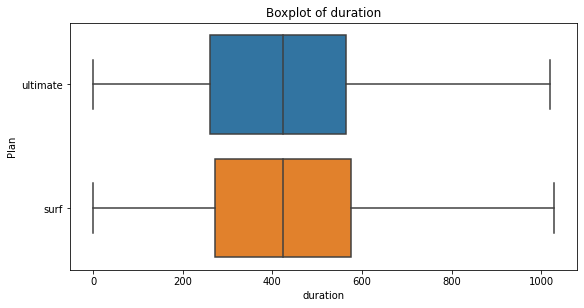

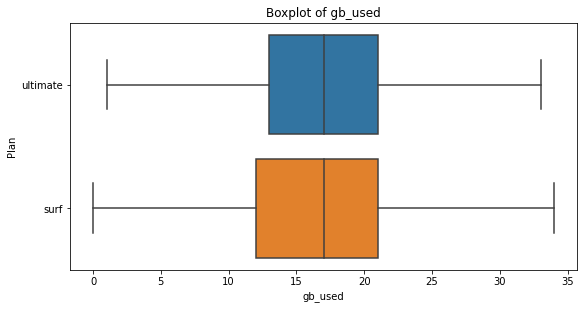

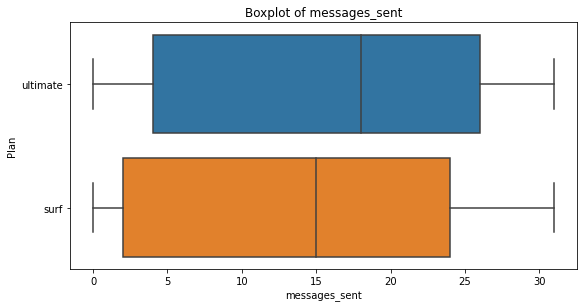

In [ ]:
# Iterate through the parameters of interest
for parameter in ['duration', 'gb_used', 'messages_sent']:
    boxplot_func(parameter)

A conclusion for boxplot graphs:

- In both of the plans - surf and ultimate the duration of calls is similar
- The usage of internet for ultimate plan users is slightly higher and less variated (the box is smaller)
- The users of the ultimate plan sent more messages than the users of surf plan

In [ ]:
def description_func(parameter):
    print('The histogram of: {}'.format(parameter))
    ax = sns.histplot(data=final, bins=70, x=parameter, hue='plan')
    print('-'*40)
    print('Statistics on: {}'.format(parameter))
    print('Standard deviation is {}'.format(final[parameter].std()))
    print('Variance is {}'.format(final[parameter].var()))
    print('Mean is {}'.format(final[parameter].mean()))

The histogram of: duration
----------------------------------------
Statistics on: duration
Standard deviation is 236.3200769532499
Variance is 55847.17877118995
Mean is 429.2834714348016


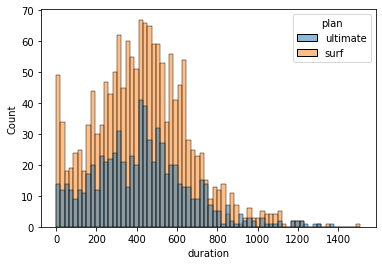

In [ ]:
description_func('duration')

The histogram of: gb_used
----------------------------------------
Statistics on: gb_used
Standard deviation is 7.796174476419775
Variance is 60.78033646677916
Mean is 16.870475359790667


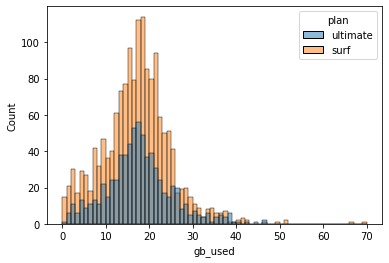

In [ ]:
description_func('gb_used')

The histogram of: messages_sent
----------------------------------------
Statistics on: messages_sent
Standard deviation is 10.772946952516904
Variance is 116.05638604174324
Mean is 14.49760139555168


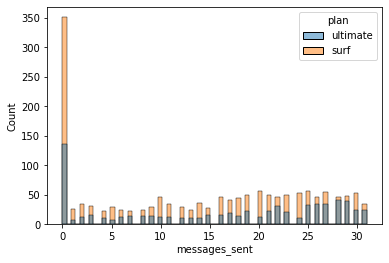

In [ ]:
description_func('messages_sent')

We can say, according to our graphs, that typically ultimate plan users had shorter conversations, less gygabytes used and less messages than users with surf plan.

# 4 Test the hypotheses

Our task now is to check to things: 

1. The average revenue from users of Ultimate and Surf calling plans differs.

2. The average revenue from users in NY-NJ area is different from that of the users from other regions.

### 4.1 First, we need to separate the dataframe according to plans

In [ ]:
ultimate = final.query('plan == "ultimate"')
ultimate.head()

,index,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,gb_used,duration,messages_sent,revenue
0,0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,12.0,2.0,124.0,7.0,70.0
19,19,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,11.0,3.0,10.0,3.0,70.0
20,20,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,12.0,32.0,59.0,31.0,84.0
26,26,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2018-12-31,10.0,17.0,476.0,16.0,70.0
27,27,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2018-12-31,11.0,24.0,446.0,21.0,70.0


In [ ]:
surf = final.query('plan == "surf"')
surf.head()

,index,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,gb_used,duration,messages_sent,revenue
1,1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,8.0,7.0,182.0,14.0,20.0
2,2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,9.0,14.0,315.0,23.0,20.0
3,3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,10.0,22.0,393.0,25.0,90.0
4,4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,11.0,19.0,426.0,19.0,60.0
5,5,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,12.0,19.0,412.0,25.0,60.0


In [ ]:
# Store all the revenue values in a variable
surf_revenue = surf['revenue']
surf_revenue

1        20.0
2        20.0
3        90.0
4        60.0
5        60.0
        ...  
2298    100.0
2299     20.0
2300     70.0
2301     40.0
2302     90.0
Name: revenue, Length: 1579, dtype: float64

In [ ]:
ultimate_revenue = ultimate['revenue']
ultimate_revenue

0       70.0
19      70.0
20      84.0
26      70.0
27      70.0
        ... 
2268    70.0
2269    70.0
2270    70.0
2271    70.0
2287    70.0
Name: revenue, Length: 724, dtype: float64

Now that our data is filtered and ready lets formulate our null hypothesis: that would be a status quo statement that there really is no difference between the mean revenue of ultimate plan user and surf plan users:

$ H_{0}:$ $\bar{x}_{surf} = \bar{x}_{ultimate} $

Then the alternative hypothesis states that surf users and ultimate users bring in a different revenue:

$ H_{1}:$ $\bar{x}_{surf} \neq \bar{x}_{ultimate} $

Because we are comparing the means of two independent groups we choose to perform a t-test. Knowing that the t-test requires the variances in both samples to be homogeneous before performing it we will run the Leven's test. Levene's test has its' own null hypothesis, stating that the groups we're comparing all have equal variances.
If this is true, we'll probably find slightly different variances in our samples. However, very different sample variances suggests that the samples' variances weren't equal after all. In this case we'll reject the null hypothesis of equal population variances. If the resulting p-value of Leven's test will be less than our level of significance (0.05), it would indicate that the resulting differences in sample variances are unlikely to occur and the null hypothesys will be rejected.

In [ ]:
alpha = 0.05 # stating the level of statistical significance

In [ ]:
st.levene(surf_revenue, ultimate_revenue, center='mean')       

LeveneResult(statistic=658.4651628443432, pvalue=6.322146582859326e-128)

As we see, the p-value of significance is quite high and it means that our variances are different enough that we must reflect it in the `st.ttest_ind()` by passing the `equal_var=False` argument.

In [ ]:
results1 = st.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

In [ ]:
print('p-value:', results1.pvalue)

p-value: 0.013758505144333825


This is the result of our t-test, lets compare it to the significance level and see if we can or can not reject the null hypotheses.

In [ ]:
if results1.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

We reject the null hypothesis


In [ ]:
print('Surf plan average revenue is', surf_revenue.mean())
print('Ultimate plan average revenue is', ultimate_revenue.mean())

Surf plan average revenue is 76.87302089930336
Ultimate plan average revenue is 72.3011049723757


If the sample was done properly and is representing the general population, then we can state with 95% confidence that there is some difference between average revenue from users with Ultimate and Surf plans. Have a look at the average revenues - Surf plan users brought in slightly higher profits. 
Otherwise, we don't know the answer.

### 4.2 Lets filter our data again by regions

In [ ]:
# Filter out all of the users from  NY-NJ region
ny_nj_reg = final[final['city'].str.contains("NY")]
ny_nj_reg

,index,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,gb_used,duration,messages_sent,revenue
56,56,1014,Edmundo,Simon,61,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-25,surf,2018-12-31,11.0,2.0,163.0,5.0,20.0
57,57,1014,Edmundo,Simon,61,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-25,surf,2018-12-31,12.0,8.0,1114.0,27.0,204.2
75,75,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,5.0,5.0,302.0,0.0,20.0
76,76,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,6.0,23.0,490.0,0.0,100.0
77,77,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,7.0,10.0,475.0,0.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,2294,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,2018-12-31,8.0,20.0,266.0,0.0,70.0
2295,2295,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,2018-12-31,9.0,23.0,363.0,0.0,100.0
2296,2296,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,2018-12-31,10.0,21.0,298.0,0.0,80.0
2297,2297,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,2018-12-31,11.0,19.0,223.0,0.0,60.0


In [ ]:
other_regions = final[~ final['city'].str.contains("NY")]
other_regions

,index,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,gb_used,duration,messages_sent,revenue
0,0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,12.0,2.0,124.0,7.0,70.0
1,1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,8.0,7.0,182.0,14.0,20.0
2,2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,9.0,14.0,315.0,23.0,20.0
3,3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,10.0,22.0,393.0,25.0,90.0
4,4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,11.0,19.0,426.0,19.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,2287,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,2018-12-31,12.0,11.0,300.0,20.0,70.0
2299,2299,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,2018-12-31,9.0,13.0,346.0,0.0,20.0
2300,2300,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,2018-12-31,10.0,20.0,385.0,0.0,70.0
2301,2301,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,2018-12-31,11.0,17.0,308.0,0.0,40.0


Let's repeat the same reasoning now for our other groups and formulate the hypothesis:

Null hypothesis: there is really no differnce between the revenues from users in NY-NJ region and users from all the other regions:


$ H_{0}:$ $\bar{x}_{ny-nj reg} = \bar{x}_{other regions} $

And the alternative hypothesis that states that users from NY-NJ region and all of the other users bring in a different revenue:

$ H_{1}:$ $\bar{x}_{ny-nj reg} \neq \bar{x}_{other regions} $


In [ ]:
# Store all the revenues in variables
ny_nj_revenue = ny_nj_reg['revenue']
other_revenue = other_regions['revenue']

The groups we are comparing are again independent, we use the same algorythm here: first the Leven's test to get an impressioin about the groups' variances, and then we can run the t-test.

In [ ]:
st.levene(ny_nj_revenue, other_revenue, center='mean')

LeveneResult(statistic=0.8617937321408381, pvalue=0.3533345827121216)

The p-level of significance is showing us the same picture as with previous groups - the variances are not equal. Now we are ready to run the t-test.

In [ ]:
results2 = st.ttest_ind(ny_nj_reg['revenue'], other_regions['revenue'], equal_var=False)

In [ ]:
print('p-value:', results2.pvalue)

p-value: 0.22640383641029482


In [ ]:
if results2.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

We can't reject the null hypothesis


In [ ]:
print('NY-NJ region average revenue is', ny_nj_reg['revenue'].mean())
print('Other regions average revenue is', other_regions['revenue'].mean())

NY-NJ region average revenue is 72.41203931203931
Other regions average revenue is 76.08481012658227


Well, recalling our null hypothesis looks like we don't have enough grounds to reject it. So again, with a condition that our sample is representative, we can say with 95% confidence that the average revenue of NY-NJ regions users and all of the other regions are the same.

# 5 Overall conclusion

**1. Preparing the data** 

In this analysis 5 datasets took part: 

- Information about 500 random users for the year 2018 - their names, age, city, activity period and plan they used 
- A reference table with information about the plans - how many minutes, gigabytes and messages are included,  fees and overage charges according to plan. 
- 3 dataframes with logs on calls, messages and traffic for each user and month.

Using the `info()` method we observed errors in datatype for all of the columns with dates which was fixed, and missing values. All of the missing values were located in the 'churn_date' column and knowing that the values were missing for the active users we replaced them with the last date of the year 2018. 

**2. Calculations** 

Using a custom function we checked the forms of the distribution, stated that they were normal and ommited the zeros that were found in the duration of calls and megabytes used columns. 

Neither one of the dataframes had duplicates. 

After preprocessing the data with the above mentioned steps, we added information to our data, such as: 
- A month column to work with
- A column for gigabytes. 

For each user were found: 
- The duration of minutes of calls per month
- The number of text messages sent per month
- The volume of data per month
- The monthly revenue


**3. Analysis and visualisation**

Building two custom functions, 1 for boxplots and 1 for histogramms we built visualizations for parameters of interest - ammount of messages, duration of calls and volume of data, and this is what we concluded: 

- In both of the plans - surf and ultimate the duration of calls were similar
- The usage of internet for ultimate plan users is slightly higher and varies less
- The users of the ultimate plan sent more messages than the users of surf plan
- Typically ultimate plan users had shorter conversations, less gygabytes used and less messages than users with surf plan

**4. Testing the hypotheses**

We had to statements to check:
1. The average revenue from users of Ultimate and Surf calling plans differs, Surf plan users broght in slightly more revenue.
2. The average revenue from users in NY-NJ area is different from that of the users from other regions.

By deviding our dataframe to two different groups according to each statement and running statistical tests, such as t-test and Leven's test we managed to find out that for the first case the average revenue from users of Ultimate and Surf calling plans differs. For the second case we could not obtain statistically significant results and we found out that the average revenue of NY-NJ regions and all of the other regions are the same.